In [1]:
import sys
import os
from google.colab import drive
from PIL import Image
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
data_path = '/content/gdrive/My Drive/DL challenge/exercise4'
sys.path.append(data_path)

# Few-shot learning - Exercise 5 WS22/23

## Introduction 
 
Few-shot learning strives to learn models which can generalize to novel tasks based on task-agnostic information extracted from a large set of tasks. A task can be seen as a separate dataset containing its own training (referred to as support data) and validation samples (referred to as query data) for a novel set of classes.

The objective is to predict the target for the predictors of the query data, given the predictors and labels of the support data. An N-way K-shot problem refers to problems where each tasks contains N classes with K labeled support samples given.

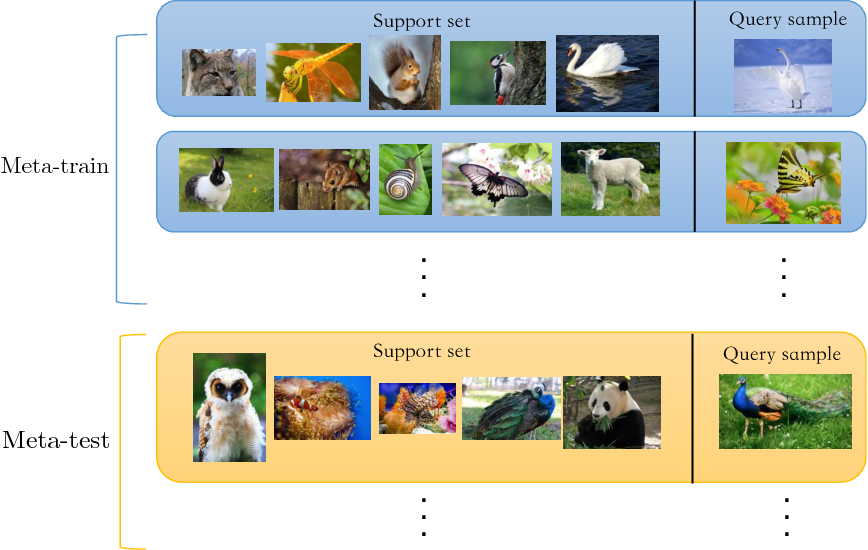

In [ ]:
Image.open(os.path.join(data_path,"fs.png"))

There are different techniques to tackle few-shot classification with the most popular ones being:

    - gradient-based
    - metric-based
    - memory-based

### [MAML](http://proceedings.mlr.press/v70/finn17a/finn17a.pdf)
 
The most well-known gradient based approache for few-shot learning strives to find model weights during meta-learing for a base model which can be used for fine-tuning on novel tasks in meta-testing with the idea that the model converges very quickly with only few samples.

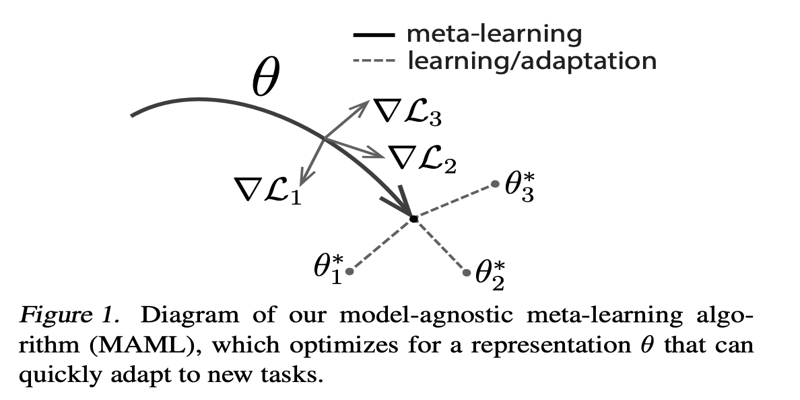

In [7]:
Image.open(os.path.join(data_path,"maml.png")).resize((800,400))

## Exercise

1. Implement MAML using the given base model and evaluate it on the omniglot data from our challenge for 5-way 5-shot.

2. MAML is fixed in its output space due to the static outputlayer. However, learning fixed weights makes no sense as the classes in a new task are random in its order. Our work [HIDRA](https://epubs.siam.org/doi/pdf/10.1137/1.9781611976236.45) solved this problem by limiting the base model to a single master output neuron which gets copied N times when conducting inference on a task with N classes.
Adapt your MAML approach and the base model to handle varying classes by implementing HIDRA.

MAML + Hidra Pseudocode:
    
    1.  Get task from meta batch
    1.5 Copy master output neuron N times
    2.  Train k steps on support data of task starting from initial parameters
    3.  Compute Loss on query data
    4.  Compute gradients of query loss with respect to initial parameters 
    5.  Average gradients for all tasks in meta-batch
    5.5 Average gradients across output neurons and update single master output
    6.  Update initial weights with optimizer of your choice


In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import time

from omni import taskGen

In [4]:
meta_train = np.load(os.path.join(data_path,"data/omni_train.npy"))

In [5]:
meta_train.shape

(964, 20, 28, 28)

In [ ]:
# If you want to experiment with train/val:
#meta_val   = meta_train[:250]
#meta_train = meta_train[250:]

In [19]:
meta_val_exp   = meta_train[:250]
meta_train_exp = meta_train[250:]

In [20]:
"""BaseModel; Use include_top=True for Reptile and include_top=False for ProtoFS (You can change the model but I strongly recommend
to first have a working meta-learning approach with this model)"""
class BaseModel(tf.keras.Model):
    def __init__(self, num_classes=5, filters=16, include_top=True):
        super(BaseModel, self).__init__()
        
        self.include_top = include_top
        
        self.block1 = self.getConvBlock(filters)
        self.block2 = self.getConvBlock(filters)
        self.block3 = self.getConvBlock(filters)
        self.block4 = self.getConvBlock(filters)
        
        self.flatten = tf.keras.layers.Flatten()
        if include_top:
            self.d1 = tf.keras.layers.Dense(32, activation='relu')
            self.d2 = tf.keras.layers.Dense(num_classes)

    def call(self, x, training=True):
        
        x = self.block1(x,training=training)
        x = self.block2(x,training=training)
        x = self.block3(x,training=training)
        x = self.block4(x,training=training)

        x = self.flatten(x)
        
        if self.include_top:
            x = self.d1(x)
            x = self.d2(x)
        
        return x
    
    def getConvBlock(self, filters):
        layers = [
        tf.keras.layers.Conv2D(filters, 3, strides=1, activation=None, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D()]
        return tf.keras.Sequential(layers)

## 1. MAML implementation

In [147]:
# Hyperparamters for this experiment

# Fixed
NWAYS = 5
S_SHOTS = 5
Q_SHOTS = 5

# Changeable; These parameters give an okay performance if your meta-learning approach is set up correctly
MB_SIZE = 32
EPOCHS = 1000 #TODO
# EPOCHS = 3

# MAML
outerstepsize = 0.1
# outerstepsize = 0.4
innerstepsize = 0.1
# innerstepsize = 0.4
innerepochs   = 5

In [148]:
model = BaseModel(num_classes=NWAYS)

optimizer = tf.keras.optimizers.SGD(learning_rate=innerstepsize)
mse_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
_ = model(np.ones([25,28,28,1]))

In [24]:
# model.summary()

### MAML training:

In [149]:
# train_gen = taskGen(meta_train, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)

# If you want to use a validation set
train_gen = taskGen(meta_train_exp, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)
val_gen = taskGen(meta_val_exp, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)

MAML Pseudocode:
    
    1. Get task from meta batch
    2. Train k steps on support data of task starting from initial parameters
    3. Compute Loss on query data
    4. Compute gradients of query loss with respect to initial parameters 
    5. Average gradients for all tasks in meta-batch
    6. Update initial weights with optimizer of your choice

In [150]:
@tf.function
def train_on_batch(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        YHat = model(x,training=True)
        loss = mse_loss_fn(y, YHat)   
        grads = tape.gradient(loss, model.trainable_weights)   
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

In [151]:
# inner_optimizer = optimizers.Adam(innerstepsize)
inner_optimizer = tf.keras.optimizers.SGD(learning_rate=innerstepsize)

# outer_optimizer = optimizers.Adam(outerstepsize)
outer_optimizer = tf.keras.optimizers.SGD(learning_rate=outerstepsize)

In [146]:
 # Train MAML
from tensorflow.keras import optimizers, utils

start = time.time()
losses = []
val_losses = []
val_accs = []

train_progbar = utils.Progbar(EPOCHS)


acc_metric = tf.keras.metrics.Accuracy()

for epoch in range(1,EPOCHS+1):


    if epoch==1 or epoch%100==0:
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))
       

    msup_x, msup_y, mque_x, mque_y = next(train_gen)

    # train_progbar = utils.Progbar(len(msup_x))

    
    weight_res = []
    ml = []
    task_weights =[]

    
    # 1. Get task from meta batch
    for task_id, (sup_x, sup_y) in enumerate(zip(msup_x,msup_y)):

        weights_before = model.get_weights()
        trainable_weights_before = model.trainable_weights
        
        inner_loss = []
      
        # 2. Train k steps on support data of task starting from initial parameters
        for k in range(innerepochs):
            l = train_on_batch(model, sup_x, sup_y, inner_optimizer)
            inner_loss.append(l)

        ml.append(inner_loss)
        # get inner loop weights:
        task_weights.append(model.get_weights())

        # train_progbar.update(task_id+1, [('inner loss:', inner_loss)])
        # train_progbar.update(task_id+1)


    # 2nd gradient update:
    all_que_grads_mb = []
    # all_que_losses = []
    # meta_loss = 0
    for task_id, (que_x, que_y) in enumerate(zip(mque_x,mque_y)):
      with tf.GradientTape() as tape:
          # set the initial weights from task task_id:
          model.set_weights(task_weights[task_id])
          
          # 3. Compute Loss on query data
          que_y_hat = model(que_x, training=True) #get preds, TODO: check
          que_loss = mse_loss_fn(que_y, que_y_hat)  
          # meta_loss += que_loss
          
          # 4. Compute gradients of query loss with respect to initial parameters 
          que_grads = tape.gradient(que_loss, model.trainable_weights)   
          # que_grads = tape.gradient(que_loss, trainable_weights_before)   
          
          all_que_grads_mb.append(que_grads)

      # meta_loss = meta_loss / float(len(meta_train)) #average loss
      # 4. Compute gradients of query loss with respect to initial parameters 
      # TODO: check weights here
      # que_grads = tape.gradient(que_loss, weights_before)   
      # que_grads = tape.gradient(que_loss, trainable_weights_before)   
      # que_grads = tape.gradient(que_loss, model.trainable_weights)   
      # que_grads = tape.gradient(meta_loss, model.trainable_weights)   

      # all_que_grads_mb.append(que_grads)
          

    # # # 5. Average gradients for all tasks in meta-batch
    # avg_grads_mb = np.mean(all_que_grads_mb) #TODO: tf.math.mean?

    
    # # 6. Update initial weights with optimizer of your choice
    # model.set_weights(avg_grads_mb)
        
    losses.append(ml)    

    # 5. Average gradients for all tasks in meta-batch
    # avg_grads_mb = [tf.reduce_mean([w[i] for w in all_grads_mb],0) for i in range(len(model.weights))]
    avg_grads_mb = [tf.reduce_mean([w[i] for w in all_que_grads_mb],0) for i in range(len(model.trainable_weights))]

    # check shapes
    # print("avg grads mbweights_before:", np.array(avg_grads_mb).shape)
    # print("bweights_before:", np.array(trainable_weights_before).shape)
    # print("trainable weights::", np.array(model.trainable_weights).shape)

    model.set_weights(weights_before)

    # 6. Update initial weights with optimizer of your choice
    # model.set_weights([avg_grads_mb * outerstepsize for i in range(len(model.weights))])
    # model.set_weights([ weights_before[i] + avg_grads_mb[i] * outerstepsize for i in range(len(model.weights))])
    # model.set_weights([ trainable_weights_before[i] + avg_grads_mb[i] * outerstepsize for i in range(len(trainable_weights_before))])
    outer_optimizer.apply_gradients(zip(avg_grads_mb, model.trainable_weights))
    # outer_optimizer.apply_gradients(zip(que_grads, model.trainable_weights))

    ############################ validation 
    # computing loss over validation set:
    msup_x_val, msup_y_val, mque_x_val, mque_y_val = next(val_gen)

    val_losses_each = []
    val_acc_each = []

    for (sup_x_val, sup_y_val, que_x_val, que_y_val) in zip(msup_x_val, msup_y_val, mque_x_val, mque_y_val):
      y_hat_val = model(que_x, training=True) #get preds, TODO: check
      val_loss = mse_loss_fn(que_y_val, y_hat_val)   
      val_losses_each.append(val_loss)

      acc_metric.update_state(que_y_val, [np.argmax(x) for x in y_hat_val])
      val_acc = acc_metric.result().numpy()
      val_acc_each.append(val_acc)

    mean_loss = np.mean(val_losses_each)
    # val_losses.append(mean_loss)
    val_losses.append(val_losses_each)
    # mean_acc = np.mean(val_acc_each)
    # val_accs.append(mean_acc)
    val_accs.append(val_acc_each)

    
    train_progbar.update(epoch, [("val loss:", mean_loss), 
                                 ("val acc:",val_acc)])


print(f"Finished in {time.time()-start}s")
losses = np.array(losses)
val_accs = np.array(val_accs)
val_losses = np.array(val_losses)


Epoch 1/1000
  67/1000 [=>............................] - ETA: 35:18 - val loss:: 1.6611 - val acc:: 0.1982

KeyboardInterrupt: ignored

In [ ]:
plt.plot(np.mean(losses,-1))

In [ ]:
plt.plot(np.mean(val_losses,-1))

In [ ]:
plt.plot(np.mean(val_accs,-1))

In [79]:
# # progressbar example
# from tensorflow.keras import optimizers, utils
# train_progbar = utils.Progbar(5)
# for i in range(10):
#   train_progbar.update(i+1)

In [ ]:
sup_x, sup_y, que_x, que_y = next(train_gen)
print("sup_x",sup_x.shape) 
print("sup_y",sup_y.shape) 
print("que_x",que_x.shape) 
print("que_y",que_y.shape)

<!-- TODO: train val split -->

## Evaluate your approach

In [ ]:
# Predictors of the test data
test_que_x = np.load(os.path.join(data_path,"data/test_que_x.npy"))
test_sup_x = np.load(os.path.join(data_path,"data/test_sup_x.npy"))
test_sup_y = np.load(os.path.join(data_path,"data/test_sup_y.npy"))
print("sup_x",test_sup_x.shape) 
print("sup_y",test_sup_y.shape) 
print("que_x",test_que_x.shape) 

In [ ]:
# loading the real labels:
test_que_y = np.load(os.path.join(data_path,"data/test_que_y.npy"))


In [ ]:
# Eval MAML
weights_init = model.get_weights()
preds = []
for t in range(len(test_que_x)):
    model.set_weights(weights_init)
    
    sup_x, sup_y, que_x, que_y = test_sup_x[t], test_sup_y[t], test_que_x[t], test_que_y[t]
    inner_loss = []
    for k in range(innerepochs):
        l = train_on_batch(model, sup_x, sup_y, inner_optimizer) #check eval
    
    preds.append(np.argmax(model(que_x),-1))

In [ ]:
np.mean(test_que_y == np.array(preds))

In [ ]:
# TODO: retrain on full dataset & implement HIDRA

## 2. MAML with Hidra implementation

In [ ]:
# TODO